In [1]:
import pandas as pd
import numpy as np
import os
import glob
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input
from sklearn import preprocessing

import tensorflow as tf
import tensorflow

import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



Using all the data, using a previous model to predict the auroral regions

In [2]:

file_load_df_cumulative = '../ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.sort_values(by=['ID_SC', 'Datetimes'])
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)

# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])

# mask_for_2010_to_2014 = [(df_train.index.year == 2010) | (df_train.index.year == 2011)
#                          | (df_train.index.year == 2012) |(df_train.index.year == 2013)
#                          | (df_train.index.year == 2014)]
# df_train = df_train[mask_for_2010_to_2014[0]]
df_train = df_train.sort_values(by=['ID_SC', 'Datetimes'])
df_val = df_val.sort_values(by=['ID_SC', 'Datetimes'])

# Construct X and y
feature_cols = [c for c in df_train.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

In [3]:
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))


scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

In [4]:



filename = 'best_auroral_region_predictor'

model = tensorflow.keras.models.load_model(filename)

## Can also load it this way:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))

# model.add(Dense(64, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(3,activation='softmax'))

# #compile model using accuracy to measure model performance
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',  metrics=['accuracy'])

# # model.load_weights('best_auroral_region_predictor_weights.h5')


results_aurora = (model.predict_classes(X))
results_aurora_val = (model.predict_classes(X_test))

W0929 05:42:31.279669 139637110437696 deprecation.py:323] From <ipython-input-4-6bfd44b8242f>:21: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [5]:
print(results_aurora == 0)
X_train_A = X_train_scaled[results_aurora == 0,:]
y_train_log_A = y_train_log[results_aurora == 0]
X_val_A = X_val_scaled[results_aurora_val == 0,:]
y_val_log_A = y_val_log[results_aurora_val == 0]
X_train_E = X_train_scaled[results_aurora == 1,:]
y_train_log_E = y_train_log[results_aurora == 1]
X_val_E = X_val_scaled[results_aurora_val == 1,:]
y_val_log_E = y_val_log[results_aurora_val == 1]
X_train_P = X_train_scaled[results_aurora == 2,:]
y_train_log_P = y_train_log[results_aurora ==2 ]
X_val_P = X_val_scaled[results_aurora_val == 2,:]
y_val_log_P = y_val_log[results_aurora_val ==2]

X_train_E.shape
y_train_log_E


[False False False ... False False False]


Datetimes
1987-01-12 12:57:00    8.313409
1987-01-12 12:58:00    8.399646
1987-01-12 13:01:00    8.650225
1987-01-28 19:08:00    7.834058
1987-01-28 19:09:00    8.047274
                         ...   
2014-12-31 22:50:00    8.348612
2014-12-31 22:51:00    8.487732
2014-12-31 22:52:00    8.282754
2014-12-31 22:53:00    8.355234
2014-12-31 22:54:00    9.064773
Name: ELE_TOTAL_ENERGY_FLUX, Length: 925990, dtype: float64

In [7]:
print(y_train_log_E.shape[0],y_val_log_E.shape[0])
print(y_train_log_A.shape[0],y_val_log_A.shape[0])
print(y_train_log_P.shape[0],y_val_log_P.shape[0])

925990 26821
496715 14856
415578 13533


In [6]:
import tensorflow.keras as k
# JZ optimal model #3
modelE = k.models.Sequential()
modelE.add(k.layers.Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
modelE.add(k.layers.Dropout(0.5))
modelE.add(k.layers.Dense(64,  activation='relu'))
modelE.add(k.layers.Dense(32, activation='relu'))
modelE.add(k.layers.Dense(256, activation='relu'))
modelE.add(k.layers.Dense(1024, activation='relu'))
modelE.add(k.layers.Dense(256,  activation='relu'))
modelE.add(k.layers.Dense(32, activation='relu'))
modelE.add(k.layers.Dense(4,  activation='relu'))    
modelE.add(k.layers.Dense(1,  activation='linear'))

# FIT THE MODEL
modelE.compile(loss='mse',
              optimizer = 'adam',
              metrics=['logcosh','mse','mae'])
history = modelE.fit(
                   X_train_E, y_train_log_E.values,
                    epochs=1000, 
                    batch_size=32768,
                    validation_data=(X_val_E, y_val_log_E.values),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    restore_best_weights=True,   patience=100)]    
                   )

Epoch 1/1000
29/29 [==============================] - 3s 89ms/step - loss: 21.7682 - logcosh: 2.8812 - mse: 21.7682 - mae: 3.5064 - val_loss: 3.6153 - val_logcosh: 0.9851 - val_mse: 3.6153 - val_mae: 1.5167
Epoch 2/1000
29/29 [==============================] - 2s 85ms/step - loss: 4.5662 - logcosh: 1.0770 - mse: 4.5662 - mae: 1.6187 - val_loss: 1.5818 - val_logcosh: 0.5209 - val_mse: 1.5818 - val_mae: 0.9732
Epoch 3/1000
29/29 [==============================] - 2s 81ms/step - loss: 2.2555 - logcosh: 0.6732 - mse: 2.2555 - mae: 1.1601 - val_loss: 1.0014 - val_logcosh: 0.3676 - val_mse: 1.0014 - val_mae: 0.7854
Epoch 4/1000
29/29 [==============================] - 2s 84ms/step - loss: 0.9541 - logcosh: 0.3430 - mse: 0.9541 - mae: 0.7456 - val_loss: 0.7467 - val_logcosh: 0.2968 - val_mse: 0.7467 - val_mae: 0.7176
Epoch 5/1000
29/29 [==============================] - 2s 80ms/step - loss: 0.4821 - logcosh: 0.1876 - mse: 0.4821 - mae: 0.5112 - val_loss: 1.0412 - val_logcosh: 0.4219 - val_mse

Epoch 41/1000
29/29 [==============================] - 2s 83ms/step - loss: 0.3535 - logcosh: 0.1419 - mse: 0.3535 - mae: 0.4233 - val_loss: 0.8360 - val_logcosh: 0.3425 - val_mse: 0.8360 - val_mae: 0.8161
Epoch 42/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.3523 - logcosh: 0.1415 - mse: 0.3523 - mae: 0.4226 - val_loss: 0.8522 - val_logcosh: 0.3492 - val_mse: 0.8522 - val_mae: 0.8268
Epoch 43/1000
29/29 [==============================] - 2s 83ms/step - loss: 0.3633 - logcosh: 0.1460 - mse: 0.3633 - mae: 0.4324 - val_loss: 0.9615 - val_logcosh: 0.3928 - val_mse: 0.9615 - val_mae: 0.8943
Epoch 44/1000
29/29 [==============================] - 2s 82ms/step - loss: 0.3544 - logcosh: 0.1425 - mse: 0.3544 - mae: 0.4248 - val_loss: 0.8392 - val_logcosh: 0.3437 - val_mse: 0.8392 - val_mae: 0.8179
Epoch 45/1000
29/29 [==============================] - 2s 84ms/step - loss: 0.3497 - logcosh: 0.1406 - mse: 0.3497 - mae: 0.4208 - val_loss: 0.8612 - val_logcosh: 0.3527 - val_

Epoch 81/1000
29/29 [==============================] - 2s 82ms/step - loss: 0.3284 - logcosh: 0.1328 - mse: 0.3284 - mae: 0.4067 - val_loss: 0.7669 - val_logcosh: 0.3137 - val_mse: 0.7669 - val_mae: 0.7625
Epoch 82/1000
29/29 [==============================] - 2s 82ms/step - loss: 0.3232 - logcosh: 0.1307 - mse: 0.3232 - mae: 0.4019 - val_loss: 0.8901 - val_logcosh: 0.3644 - val_mse: 0.8901 - val_mae: 0.8467
Epoch 83/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.3224 - logcosh: 0.1303 - mse: 0.3224 - mae: 0.4013 - val_loss: 0.7534 - val_logcosh: 0.3083 - val_mse: 0.7534 - val_mae: 0.7533
Epoch 84/1000
29/29 [==============================] - 2s 83ms/step - loss: 0.3252 - logcosh: 0.1316 - mse: 0.3252 - mae: 0.4046 - val_loss: 0.8974 - val_logcosh: 0.3671 - val_mse: 0.8974 - val_mae: 0.8498
Epoch 85/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.3211 - logcosh: 0.1301 - mse: 0.3211 - mae: 0.4012 - val_loss: 0.7550 - val_logcosh: 0.3086 - val_

Epoch 121/1000
29/29 [==============================] - 1s 49ms/step - loss: 0.2734 - logcosh: 0.1123 - mse: 0.2734 - mae: 0.3656 - val_loss: 0.6132 - val_logcosh: 0.2487 - val_mse: 0.6132 - val_mae: 0.6299
Epoch 122/1000
29/29 [==============================] - 1s 49ms/step - loss: 0.2710 - logcosh: 0.1111 - mse: 0.2710 - mae: 0.3626 - val_loss: 0.6578 - val_logcosh: 0.2691 - val_mse: 0.6578 - val_mae: 0.6719
Epoch 123/1000
29/29 [==============================] - 1s 49ms/step - loss: 0.2703 - logcosh: 0.1110 - mse: 0.2703 - mae: 0.3626 - val_loss: 0.6068 - val_logcosh: 0.2451 - val_mse: 0.6068 - val_mae: 0.6211
Epoch 124/1000
29/29 [==============================] - 1s 50ms/step - loss: 0.2715 - logcosh: 0.1114 - mse: 0.2715 - mae: 0.3636 - val_loss: 0.5890 - val_logcosh: 0.2377 - val_mse: 0.5890 - val_mae: 0.6056
Epoch 125/1000
29/29 [==============================] - 1s 49ms/step - loss: 0.2725 - logcosh: 0.1119 - mse: 0.2725 - mae: 0.3654 - val_loss: 0.5869 - val_logcosh: 0.2367 -

Epoch 200/1000
29/29 [==============================] - 2s 85ms/step - loss: 0.2569 - logcosh: 0.1061 - mse: 0.2569 - mae: 0.3542 - val_loss: 0.4756 - val_logcosh: 0.1900 - val_mse: 0.4756 - val_mae: 0.5021
Epoch 201/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.2260 - logcosh: 0.0933 - mse: 0.2260 - mae: 0.3211 - val_loss: 0.4904 - val_logcosh: 0.1979 - val_mse: 0.4904 - val_mae: 0.5226
Epoch 202/1000
29/29 [==============================] - 2s 85ms/step - loss: 0.2239 - logcosh: 0.0924 - mse: 0.2239 - mae: 0.3189 - val_loss: 0.4869 - val_logcosh: 0.1961 - val_mse: 0.4869 - val_mae: 0.5179
Epoch 203/1000
29/29 [==============================] - 2s 83ms/step - loss: 0.2237 - logcosh: 0.0924 - mse: 0.2237 - mae: 0.3190 - val_loss: 0.4747 - val_logcosh: 0.1887 - val_mse: 0.4747 - val_mae: 0.4977
Epoch 204/1000
29/29 [==============================] - 3s 87ms/step - loss: 0.2235 - logcosh: 0.0923 - mse: 0.2235 - mae: 0.3186 - val_loss: 0.4733 - val_logcosh: 0.1886 -

Epoch 279/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.2108 - logcosh: 0.0871 - mse: 0.2108 - mae: 0.3057 - val_loss: 0.4561 - val_logcosh: 0.1798 - val_mse: 0.4561 - val_mae: 0.4748
Epoch 280/1000
29/29 [==============================] - 2s 85ms/step - loss: 0.2124 - logcosh: 0.0878 - mse: 0.2124 - mae: 0.3082 - val_loss: 0.4638 - val_logcosh: 0.1803 - val_mse: 0.4638 - val_mae: 0.4726
Epoch 281/1000
29/29 [==============================] - 2s 80ms/step - loss: 0.2133 - logcosh: 0.0882 - mse: 0.2133 - mae: 0.3093 - val_loss: 0.4723 - val_logcosh: 0.1906 - val_mse: 0.4723 - val_mae: 0.5053
Epoch 282/1000
29/29 [==============================] - 2s 84ms/step - loss: 0.2091 - logcosh: 0.0865 - mse: 0.2091 - mae: 0.3039 - val_loss: 0.4580 - val_logcosh: 0.1810 - val_mse: 0.4580 - val_mae: 0.4785
Epoch 283/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.2095 - logcosh: 0.0866 - mse: 0.2095 - mae: 0.3043 - val_loss: 0.4736 - val_logcosh: 0.1916 -

Epoch 358/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.2081 - logcosh: 0.0862 - mse: 0.2081 - mae: 0.3046 - val_loss: 0.4547 - val_logcosh: 0.1790 - val_mse: 0.4547 - val_mae: 0.4723
Epoch 359/1000
29/29 [==============================] - 2s 83ms/step - loss: 0.2035 - logcosh: 0.0842 - mse: 0.2035 - mae: 0.2988 - val_loss: 0.4520 - val_logcosh: 0.1783 - val_mse: 0.4520 - val_mae: 0.4705
Epoch 360/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.2039 - logcosh: 0.0844 - mse: 0.2039 - mae: 0.2995 - val_loss: 0.4718 - val_logcosh: 0.1904 - val_mse: 0.4718 - val_mae: 0.5042
Epoch 361/1000
29/29 [==============================] - 2s 86ms/step - loss: 0.2021 - logcosh: 0.0836 - mse: 0.2021 - mae: 0.2971 - val_loss: 0.4708 - val_logcosh: 0.1901 - val_mse: 0.4708 - val_mae: 0.5037
Epoch 362/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.2019 - logcosh: 0.0836 - mse: 0.2019 - mae: 0.2967 - val_loss: 0.4662 - val_logcosh: 0.1880 -

Epoch 437/1000
29/29 [==============================] - 2s 84ms/step - loss: 0.1965 - logcosh: 0.0814 - mse: 0.1965 - mae: 0.2916 - val_loss: 0.4614 - val_logcosh: 0.1834 - val_mse: 0.4614 - val_mae: 0.4832
Epoch 438/1000
29/29 [==============================] - 2s 82ms/step - loss: 0.1963 - logcosh: 0.0814 - mse: 0.1963 - mae: 0.2915 - val_loss: 0.4482 - val_logcosh: 0.1762 - val_mse: 0.4482 - val_mae: 0.4649
Epoch 439/1000
29/29 [==============================] - 2s 85ms/step - loss: 0.1972 - logcosh: 0.0817 - mse: 0.1972 - mae: 0.2925 - val_loss: 0.4533 - val_logcosh: 0.1778 - val_mse: 0.4533 - val_mae: 0.4674
Epoch 440/1000
29/29 [==============================] - 2s 80ms/step - loss: 0.1962 - logcosh: 0.0813 - mse: 0.1962 - mae: 0.2912 - val_loss: 0.4522 - val_logcosh: 0.1781 - val_mse: 0.4522 - val_mae: 0.4693
Epoch 441/1000
29/29 [==============================] - 2s 85ms/step - loss: 0.1972 - logcosh: 0.0817 - mse: 0.1972 - mae: 0.2922 - val_loss: 0.4512 - val_logcosh: 0.1777 -

Epoch 516/1000
29/29 [==============================] - 2s 86ms/step - loss: 0.1923 - logcosh: 0.0798 - mse: 0.1923 - mae: 0.2881 - val_loss: 0.4553 - val_logcosh: 0.1765 - val_mse: 0.4553 - val_mae: 0.4608
Epoch 517/1000
29/29 [==============================] - 2s 82ms/step - loss: 0.1927 - logcosh: 0.0800 - mse: 0.1927 - mae: 0.2883 - val_loss: 0.4716 - val_logcosh: 0.1881 - val_mse: 0.4716 - val_mae: 0.4946
Epoch 518/1000
29/29 [==============================] - 2s 86ms/step - loss: 0.1936 - logcosh: 0.0803 - mse: 0.1936 - mae: 0.2889 - val_loss: 0.4682 - val_logcosh: 0.1867 - val_mse: 0.4682 - val_mae: 0.4911
Epoch 519/1000
29/29 [==============================] - 2s 82ms/step - loss: 0.1933 - logcosh: 0.0802 - mse: 0.1933 - mae: 0.2886 - val_loss: 0.4764 - val_logcosh: 0.1901 - val_mse: 0.4764 - val_mae: 0.4987
Epoch 520/1000
29/29 [==============================] - 2s 81ms/step - loss: 0.1941 - logcosh: 0.0806 - mse: 0.1941 - mae: 0.2903 - val_loss: 0.4615 - val_logcosh: 0.1821 -

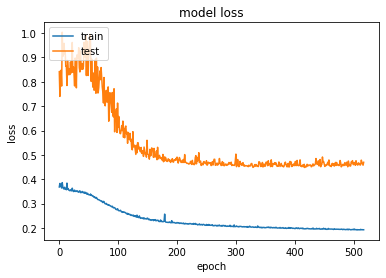

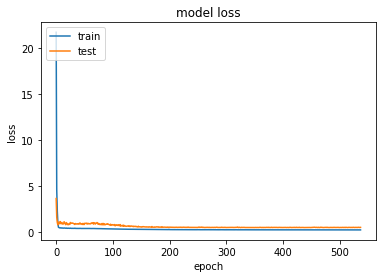

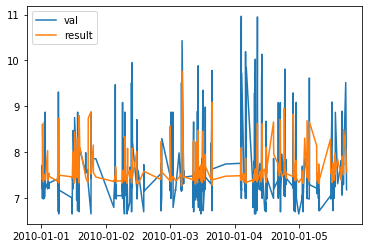

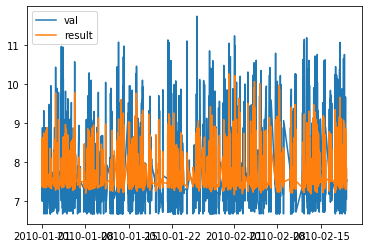

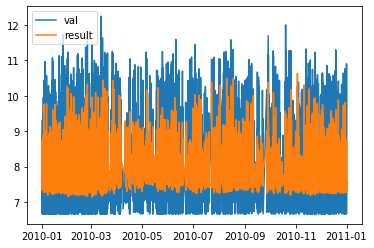

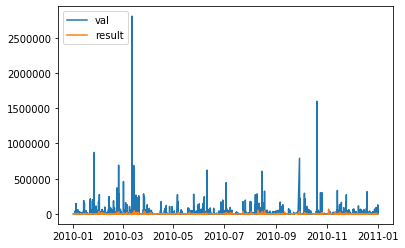

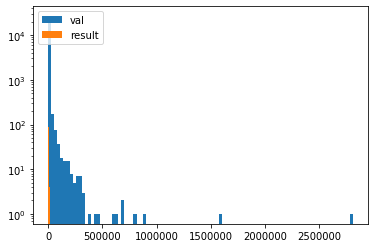

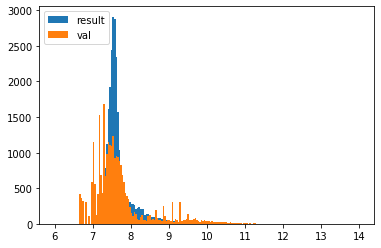

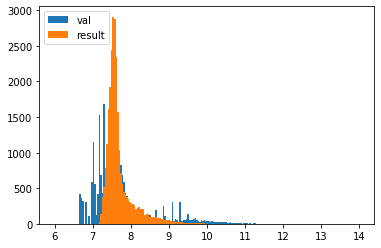

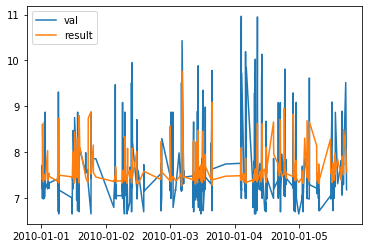

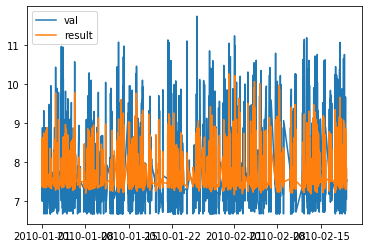

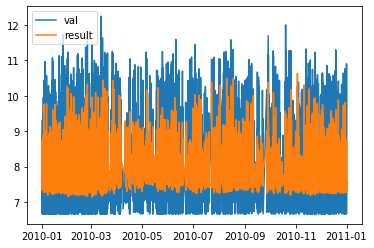

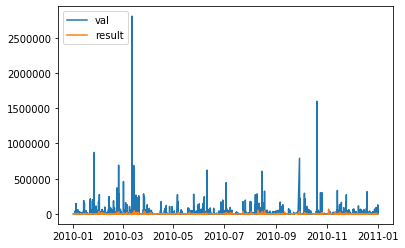

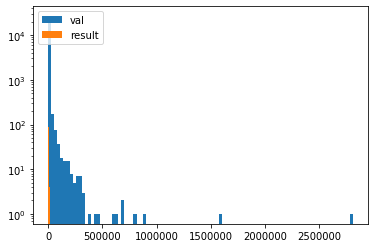

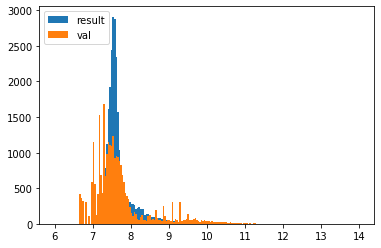

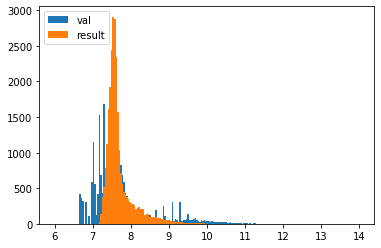

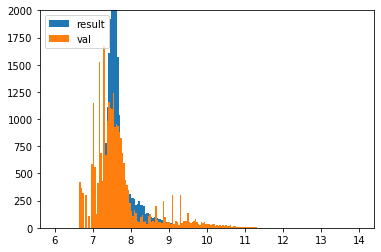

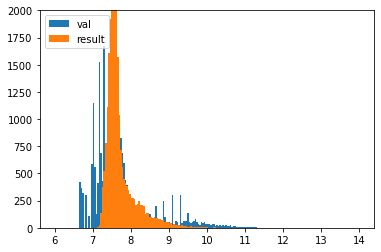

In [7]:
results = modelE.predict(X_val_E)
y_val_log = y_val_log_E


plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



df_results = pd.DataFrame(data=results, index = y_val_log.index)

%matplotlib inline

plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.ylim([0,2000])
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.ylim([0,2000])

plt.show()

In [8]:
# JZ optimal model #3
modelA = k.models.Sequential()
modelA.add(k.layers.Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
modelA.add(k.layers.Dropout(0.5))
modelA.add(k.layers.Dense(64,  activation='relu'))
modelA.add(k.layers.Dense(32, activation='relu'))
modelA.add(k.layers.Dense(256, activation='relu'))
modelA.add(k.layers.Dense(1024, activation='relu'))
modelA.add(k.layers.Dense(256,  activation='relu'))
modelA.add(k.layers.Dense(32, activation='relu'))
modelA.add(k.layers.Dense(4,  activation='relu'))    
modelA.add(k.layers.Dense(1,  activation='linear'))

# FIT THE MODEL
modelA.compile(loss='mse',
              optimizer = k.optimizers.Adam(),
              metrics=['logcosh','mse','mae'])
history = modelA.fit(
                   X_train_A, y_train_log_A.values,
                    epochs=1000, 
                    batch_size=32768,
                    validation_data=(X_val_A, y_val_log_A.values),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    restore_best_weights=True,   patience=100)]    
                   )

Epoch 1/1000
16/16 [==============================] - 1s 75ms/step - loss: 52.7889 - logcosh: 5.4150 - mse: 52.7889 - mae: 6.0771 - val_loss: 11.0095 - val_logcosh: 2.1179 - val_mse: 11.0095 - val_mae: 2.7254
Epoch 2/1000
16/16 [==============================] - 1s 82ms/step - loss: 10.8115 - logcosh: 1.9552 - mse: 10.8115 - mae: 2.5522 - val_loss: 6.3695 - val_logcosh: 1.5414 - val_mse: 6.3695 - val_mae: 2.1351
Epoch 3/1000
16/16 [==============================] - 1s 80ms/step - loss: 5.0872 - logcosh: 1.1867 - mse: 5.0872 - mae: 1.7395 - val_loss: 3.1528 - val_logcosh: 0.9750 - val_mse: 3.1528 - val_mae: 1.5468
Epoch 4/1000
16/16 [==============================] - 1s 71ms/step - loss: 2.4751 - logcosh: 0.7354 - mse: 2.4751 - mae: 1.2398 - val_loss: 2.4435 - val_logcosh: 0.8307 - val_mse: 2.4435 - val_mae: 1.4055
Epoch 5/1000
16/16 [==============================] - 1s 81ms/step - loss: 1.4497 - logcosh: 0.4888 - mse: 1.4497 - mae: 0.9447 - val_loss: 1.7231 - val_logcosh: 0.6288 - val

Epoch 41/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.9276 - logcosh: 0.3455 - mse: 0.9276 - mae: 0.7578 - val_loss: 0.9264 - val_logcosh: 0.3360 - val_mse: 0.9264 - val_mae: 0.7469
Epoch 42/1000
16/16 [==============================] - 1s 74ms/step - loss: 0.9384 - logcosh: 0.3487 - mse: 0.9384 - mae: 0.7620 - val_loss: 0.8909 - val_logcosh: 0.3093 - val_mse: 0.8909 - val_mae: 0.6896
Epoch 43/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.9679 - logcosh: 0.3582 - mse: 0.9679 - mae: 0.7743 - val_loss: 1.0031 - val_logcosh: 0.3747 - val_mse: 1.0031 - val_mae: 0.8164
Epoch 44/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.9264 - logcosh: 0.3454 - mse: 0.9264 - mae: 0.7581 - val_loss: 0.9096 - val_logcosh: 0.3273 - val_mse: 0.9096 - val_mae: 0.7307
Epoch 45/1000
16/16 [==============================] - 1s 78ms/step - loss: 0.9204 - logcosh: 0.3434 - mse: 0.9204 - mae: 0.7551 - val_loss: 0.9301 - val_logcosh: 0.3396 - val_

Epoch 81/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.8831 - logcosh: 0.3317 - mse: 0.8831 - mae: 0.7391 - val_loss: 0.9235 - val_logcosh: 0.3433 - val_mse: 0.9235 - val_mae: 0.7671
Epoch 82/1000
16/16 [==============================] - 1s 78ms/step - loss: 0.8810 - logcosh: 0.3311 - mse: 0.8810 - mae: 0.7390 - val_loss: 0.8904 - val_logcosh: 0.3261 - val_mse: 0.8904 - val_mae: 0.7351
Epoch 83/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.8764 - logcosh: 0.3298 - mse: 0.8764 - mae: 0.7370 - val_loss: 0.8624 - val_logcosh: 0.3089 - val_mse: 0.8624 - val_mae: 0.7004
Epoch 84/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.8778 - logcosh: 0.3301 - mse: 0.8778 - mae: 0.7370 - val_loss: 0.8805 - val_logcosh: 0.3212 - val_mse: 0.8805 - val_mae: 0.7261
Epoch 85/1000
16/16 [==============================] - 1s 85ms/step - loss: 0.8754 - logcosh: 0.3294 - mse: 0.8754 - mae: 0.7363 - val_loss: 0.9292 - val_logcosh: 0.3471 - val_

Epoch 121/1000
16/16 [==============================] - 1s 83ms/step - loss: 0.7802 - logcosh: 0.2971 - mse: 0.7802 - mae: 0.6869 - val_loss: 0.7866 - val_logcosh: 0.2985 - val_mse: 0.7866 - val_mae: 0.6971
Epoch 122/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.7683 - logcosh: 0.2933 - mse: 0.7683 - mae: 0.6817 - val_loss: 0.7241 - val_logcosh: 0.2675 - val_mse: 0.7241 - val_mae: 0.6349
Epoch 123/1000
16/16 [==============================] - 1s 77ms/step - loss: 0.7574 - logcosh: 0.2890 - mse: 0.7574 - mae: 0.6742 - val_loss: 0.7454 - val_logcosh: 0.2810 - val_mse: 0.7454 - val_mae: 0.6642
Epoch 124/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.7503 - logcosh: 0.2869 - mse: 0.7503 - mae: 0.6717 - val_loss: 0.7407 - val_logcosh: 0.2780 - val_mse: 0.7407 - val_mae: 0.6576
Epoch 125/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.7480 - logcosh: 0.2861 - mse: 0.7480 - mae: 0.6703 - val_loss: 0.7704 - val_logcosh: 0.2931 -

Epoch 200/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.6481 - logcosh: 0.2520 - mse: 0.6481 - mae: 0.6142 - val_loss: 0.6211 - val_logcosh: 0.2334 - val_mse: 0.6211 - val_mae: 0.5723
Epoch 201/1000
16/16 [==============================] - 1s 79ms/step - loss: 0.6499 - logcosh: 0.2524 - mse: 0.6499 - mae: 0.6146 - val_loss: 0.6549 - val_logcosh: 0.2511 - val_mse: 0.6549 - val_mae: 0.6112
Epoch 202/1000
16/16 [==============================] - 1s 77ms/step - loss: 0.6478 - logcosh: 0.2520 - mse: 0.6478 - mae: 0.6143 - val_loss: 0.6525 - val_logcosh: 0.2519 - val_mse: 0.6525 - val_mae: 0.6163
Epoch 203/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.6456 - logcosh: 0.2512 - mse: 0.6456 - mae: 0.6130 - val_loss: 0.6659 - val_logcosh: 0.2565 - val_mse: 0.6659 - val_mae: 0.6252
Epoch 204/1000
16/16 [==============================] - 1s 83ms/step - loss: 0.6518 - logcosh: 0.2532 - mse: 0.6518 - mae: 0.6161 - val_loss: 0.6260 - val_logcosh: 0.2358 -

Epoch 279/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.6152 - logcosh: 0.2402 - mse: 0.6152 - mae: 0.5945 - val_loss: 0.6358 - val_logcosh: 0.2449 - val_mse: 0.6358 - val_mae: 0.6011
Epoch 280/1000
16/16 [==============================] - 1s 77ms/step - loss: 0.6113 - logcosh: 0.2389 - mse: 0.6113 - mae: 0.5923 - val_loss: 0.6291 - val_logcosh: 0.2423 - val_mse: 0.6291 - val_mae: 0.5977
Epoch 281/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.6267 - logcosh: 0.2443 - mse: 0.6267 - mae: 0.6011 - val_loss: 0.5920 - val_logcosh: 0.2202 - val_mse: 0.5920 - val_mae: 0.5426
Epoch 282/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.6268 - logcosh: 0.2442 - mse: 0.6268 - mae: 0.6006 - val_loss: 0.6081 - val_logcosh: 0.2308 - val_mse: 0.6081 - val_mae: 0.5701
Epoch 283/1000
16/16 [==============================] - 1s 78ms/step - loss: 0.6144 - logcosh: 0.2399 - mse: 0.6144 - mae: 0.5937 - val_loss: 0.6407 - val_logcosh: 0.2469 -

16/16 [==============================] - 1s 87ms/step - loss: 0.5897 - logcosh: 0.2311 - mse: 0.5897 - mae: 0.5789 - val_loss: 0.5909 - val_logcosh: 0.2236 - val_mse: 0.5909 - val_mae: 0.5539
Epoch 358/1000
16/16 [==============================] - 1s 76ms/step - loss: 0.5968 - logcosh: 0.2337 - mse: 0.5968 - mae: 0.5835 - val_loss: 0.5975 - val_logcosh: 0.2298 - val_mse: 0.5975 - val_mae: 0.5712
Epoch 359/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.5912 - logcosh: 0.2317 - mse: 0.5912 - mae: 0.5800 - val_loss: 0.6059 - val_logcosh: 0.2333 - val_mse: 0.6059 - val_mae: 0.5793
Epoch 360/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.5926 - logcosh: 0.2320 - mse: 0.5926 - mae: 0.5806 - val_loss: 0.5837 - val_logcosh: 0.2218 - val_mse: 0.5837 - val_mae: 0.5520
Epoch 361/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.5910 - logcosh: 0.2316 - mse: 0.5910 - mae: 0.5801 - val_loss: 0.5931 - val_logcosh: 0.2263 - val_mse: 0.593

Epoch 397/1000
16/16 [==============================] - 1s 86ms/step - loss: 0.5823 - logcosh: 0.2286 - mse: 0.5823 - mae: 0.5752 - val_loss: 0.5783 - val_logcosh: 0.2189 - val_mse: 0.5783 - val_mae: 0.5446
Epoch 398/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.5874 - logcosh: 0.2304 - mse: 0.5874 - mae: 0.5780 - val_loss: 0.6211 - val_logcosh: 0.2418 - val_mse: 0.6211 - val_mae: 0.5971
Epoch 399/1000
16/16 [==============================] - 1s 79ms/step - loss: 0.5916 - logcosh: 0.2318 - mse: 0.5916 - mae: 0.5803 - val_loss: 0.5809 - val_logcosh: 0.2202 - val_mse: 0.5809 - val_mae: 0.5481
Epoch 400/1000
16/16 [==============================] - 1s 85ms/step - loss: 0.5801 - logcosh: 0.2278 - mse: 0.5801 - mae: 0.5738 - val_loss: 0.5749 - val_logcosh: 0.2155 - val_mse: 0.5749 - val_mae: 0.5344
Epoch 401/1000
16/16 [==============================] - 1s 84ms/step - loss: 0.5941 - logcosh: 0.2327 - mse: 0.5941 - mae: 0.5821 - val_loss: 0.5922 - val_logcosh: 0.2275 -

Epoch 476/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.5714 - logcosh: 0.2246 - mse: 0.5714 - mae: 0.5681 - val_loss: 0.5628 - val_logcosh: 0.2104 - val_mse: 0.5628 - val_mae: 0.5238
Epoch 477/1000
16/16 [==============================] - 1s 76ms/step - loss: 0.5720 - logcosh: 0.2248 - mse: 0.5720 - mae: 0.5685 - val_loss: 0.5661 - val_logcosh: 0.2143 - val_mse: 0.5661 - val_mae: 0.5355
Epoch 478/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.5740 - logcosh: 0.2256 - mse: 0.5740 - mae: 0.5699 - val_loss: 0.5777 - val_logcosh: 0.2212 - val_mse: 0.5777 - val_mae: 0.5532
Epoch 479/1000
16/16 [==============================] - 1s 83ms/step - loss: 0.5720 - logcosh: 0.2248 - mse: 0.5720 - mae: 0.5686 - val_loss: 0.5958 - val_logcosh: 0.2300 - val_mse: 0.5958 - val_mae: 0.5718
Epoch 480/1000
16/16 [==============================] - 1s 78ms/step - loss: 0.5767 - logcosh: 0.2265 - mse: 0.5767 - mae: 0.5712 - val_loss: 0.5732 - val_logcosh: 0.2196 -

Epoch 555/1000
16/16 [==============================] - 1s 72ms/step - loss: 0.5629 - logcosh: 0.2215 - mse: 0.5629 - mae: 0.5631 - val_loss: 0.5646 - val_logcosh: 0.2154 - val_mse: 0.5646 - val_mae: 0.5408
Epoch 556/1000
16/16 [==============================] - 1s 85ms/step - loss: 0.5611 - logcosh: 0.2211 - mse: 0.5611 - mae: 0.5625 - val_loss: 0.5582 - val_logcosh: 0.2099 - val_mse: 0.5582 - val_mae: 0.5239
Epoch 557/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.5620 - logcosh: 0.2211 - mse: 0.5620 - mae: 0.5622 - val_loss: 0.5499 - val_logcosh: 0.2076 - val_mse: 0.5499 - val_mae: 0.5230
Epoch 558/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.5601 - logcosh: 0.2206 - mse: 0.5601 - mae: 0.5617 - val_loss: 0.5697 - val_logcosh: 0.2184 - val_mse: 0.5697 - val_mae: 0.5475
Epoch 559/1000
16/16 [==============================] - 1s 83ms/step - loss: 0.5619 - logcosh: 0.2214 - mse: 0.5619 - mae: 0.5630 - val_loss: 0.5582 - val_logcosh: 0.2092 -

Epoch 634/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.5635 - logcosh: 0.2217 - mse: 0.5635 - mae: 0.5634 - val_loss: 0.5488 - val_logcosh: 0.2045 - val_mse: 0.5488 - val_mae: 0.5105
Epoch 635/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.5571 - logcosh: 0.2195 - mse: 0.5571 - mae: 0.5596 - val_loss: 0.5547 - val_logcosh: 0.2095 - val_mse: 0.5547 - val_mae: 0.5254
Epoch 636/1000
16/16 [==============================] - 1s 83ms/step - loss: 0.5560 - logcosh: 0.2191 - mse: 0.5560 - mae: 0.5589 - val_loss: 0.5777 - val_logcosh: 0.2234 - val_mse: 0.5777 - val_mae: 0.5605
Epoch 637/1000
16/16 [==============================] - 1s 75ms/step - loss: 0.5648 - logcosh: 0.2225 - mse: 0.5648 - mae: 0.5650 - val_loss: 0.5606 - val_logcosh: 0.2141 - val_mse: 0.5606 - val_mae: 0.5390
Epoch 638/1000
16/16 [==============================] - 1s 80ms/step - loss: 0.5643 - logcosh: 0.2224 - mse: 0.5643 - mae: 0.5652 - val_loss: 0.5568 - val_logcosh: 0.2064 -

Epoch 713/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.5514 - logcosh: 0.2178 - mse: 0.5514 - mae: 0.5573 - val_loss: 0.5514 - val_logcosh: 0.2104 - val_mse: 0.5514 - val_mae: 0.5307
Epoch 714/1000
16/16 [==============================] - 1s 83ms/step - loss: 0.5493 - logcosh: 0.2169 - mse: 0.5493 - mae: 0.5554 - val_loss: 0.5481 - val_logcosh: 0.2059 - val_mse: 0.5481 - val_mae: 0.5171
Epoch 715/1000
16/16 [==============================] - 1s 76ms/step - loss: 0.5496 - logcosh: 0.2169 - mse: 0.5496 - mae: 0.5554 - val_loss: 0.5431 - val_logcosh: 0.2036 - val_mse: 0.5431 - val_mae: 0.5116
Epoch 716/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.5516 - logcosh: 0.2176 - mse: 0.5516 - mae: 0.5568 - val_loss: 0.5454 - val_logcosh: 0.2038 - val_mse: 0.5454 - val_mae: 0.5106
Epoch 717/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.5523 - logcosh: 0.2178 - mse: 0.5523 - mae: 0.5568 - val_loss: 0.5433 - val_logcosh: 0.2022 -

Epoch 792/1000
16/16 [==============================] - 1s 82ms/step - loss: 0.5458 - logcosh: 0.2156 - mse: 0.5458 - mae: 0.5534 - val_loss: 0.5418 - val_logcosh: 0.2047 - val_mse: 0.5418 - val_mae: 0.5167
Epoch 793/1000
16/16 [==============================] - 1s 79ms/step - loss: 0.5461 - logcosh: 0.2158 - mse: 0.5461 - mae: 0.5539 - val_loss: 0.5441 - val_logcosh: 0.2056 - val_mse: 0.5441 - val_mae: 0.5175
Epoch 794/1000
16/16 [==============================] - 1s 83ms/step - loss: 0.5455 - logcosh: 0.2154 - mse: 0.5455 - mae: 0.5530 - val_loss: 0.5427 - val_logcosh: 0.2050 - val_mse: 0.5427 - val_mae: 0.5157
Epoch 795/1000
16/16 [==============================] - 1s 85ms/step - loss: 0.5444 - logcosh: 0.2150 - mse: 0.5444 - mae: 0.5523 - val_loss: 0.5469 - val_logcosh: 0.2061 - val_mse: 0.5469 - val_mae: 0.5177
Epoch 796/1000
16/16 [==============================] - 1s 81ms/step - loss: 0.5446 - logcosh: 0.2151 - mse: 0.5446 - mae: 0.5523 - val_loss: 0.5596 - val_logcosh: 0.2148 -

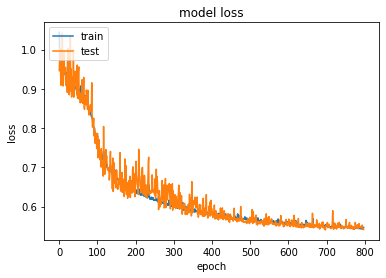

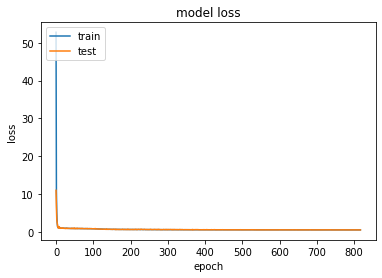

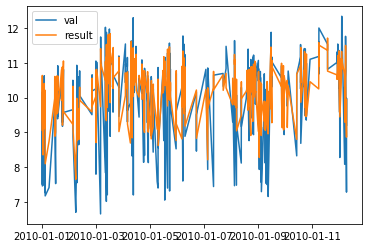

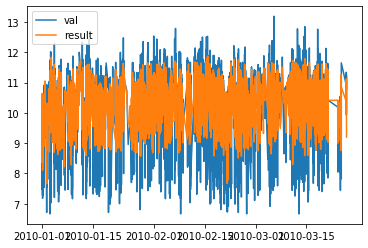

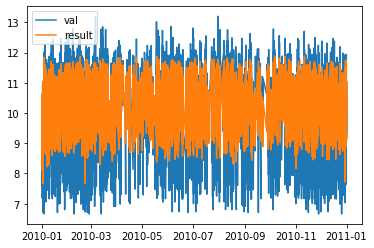

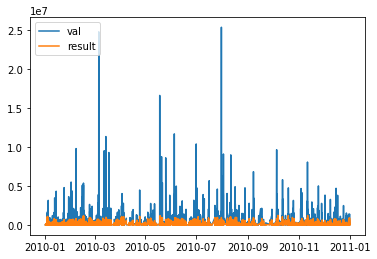

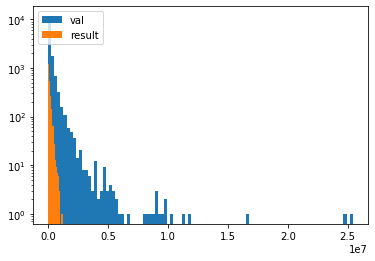

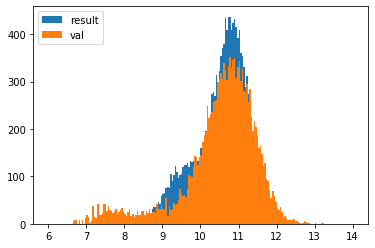

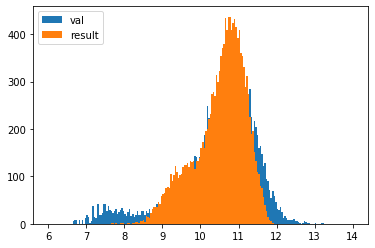

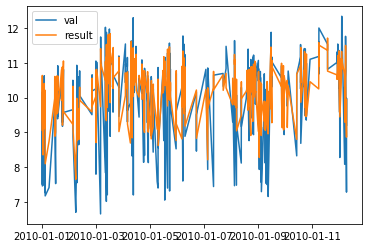

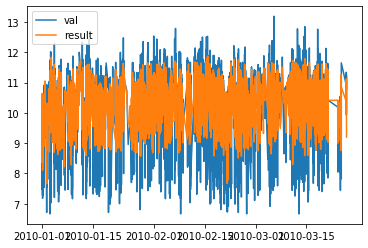

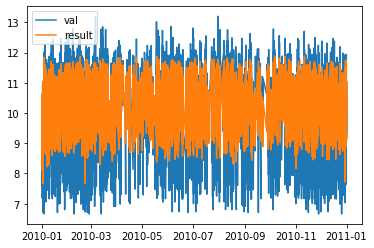

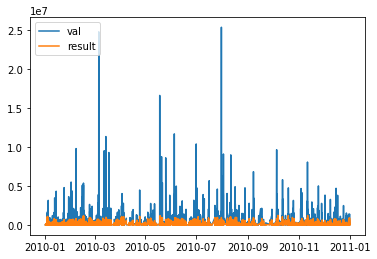

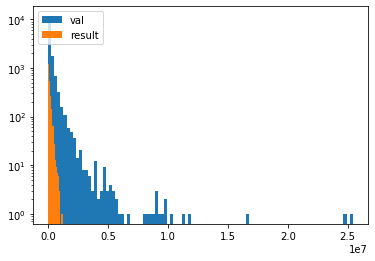

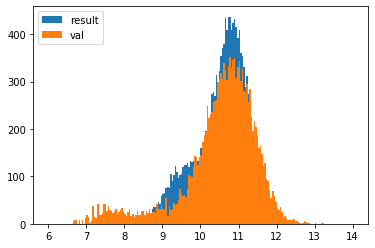

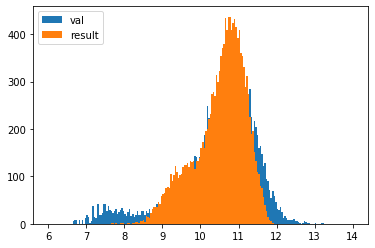

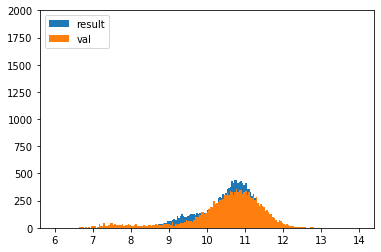

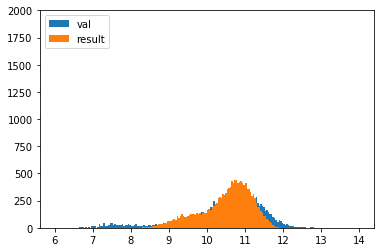

In [9]:
results = modelA.predict(X_val_A)
y_val_log = y_val_log_A


plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



df_results = pd.DataFrame(data=results, index = y_val_log.index)

%matplotlib inline

plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.ylim([0,2000])
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.ylim([0,2000])

plt.show()

In [10]:
# JZ optimal model #3
modelP = k.models.Sequential()
modelP.add(k.layers.Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
modelP.add(k.layers.Dropout(0.5))
modelP.add(k.layers.Dense(64,  activation='relu'))
modelP.add(k.layers.Dense(32, activation='relu'))
modelP.add(k.layers.Dense(256, activation='relu'))
modelP.add(k.layers.Dense(1024, activation='relu'))
modelP.add(k.layers.Dense(256,  activation='relu'))
modelP.add(k.layers.Dense(32, activation='relu'))
modelP.add(k.layers.Dense(4,  activation='relu'))    
modelP.add(k.layers.Dense(1,  activation='linear'))

# FIT THE MODEL
modelP.compile(loss='mse',
              optimizer = k.optimizers.Adam(),
              metrics=['logcosh','mse','mae'])
history = modelP.fit(
                   X_train_P, y_train_log_P.values,
                    epochs=1000, 
                    batch_size=32768,
                    validation_data=(X_val_P, y_val_log_P.values),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    restore_best_weights=True,   patience=100)]    
                   )

Epoch 1/1000
13/13 [==============================] - 1s 96ms/step - loss: 32.8834 - logcosh: 4.0409 - mse: 32.8834 - mae: 4.6867 - val_loss: 11.0237 - val_logcosh: 2.1921 - val_mse: 11.0237 - val_mae: 2.8121
Epoch 2/1000
13/13 [==============================] - 1s 86ms/step - loss: 8.5739 - logcosh: 1.6284 - mse: 8.5739 - mae: 2.2090 - val_loss: 4.5357 - val_logcosh: 1.1425 - val_mse: 4.5357 - val_mae: 1.6867
Epoch 3/1000
13/13 [==============================] - 1s 82ms/step - loss: 5.8378 - logcosh: 1.2721 - mse: 5.8378 - mae: 1.8280 - val_loss: 3.8865 - val_logcosh: 1.0388 - val_mse: 3.8865 - val_mae: 1.5755
Epoch 4/1000
13/13 [==============================] - 1s 77ms/step - loss: 4.4889 - logcosh: 1.0742 - mse: 4.4889 - mae: 1.6122 - val_loss: 3.1916 - val_logcosh: 0.9052 - val_mse: 3.1916 - val_mae: 1.4276
Epoch 5/1000
13/13 [==============================] - 1s 81ms/step - loss: 3.5432 - logcosh: 0.9225 - mse: 3.5432 - mae: 1.4447 - val_loss: 2.6187 - val_logcosh: 0.7845 - val_m

Epoch 41/1000
13/13 [==============================] - 1s 88ms/step - loss: 1.0667 - logcosh: 0.3968 - mse: 1.0667 - mae: 0.8318 - val_loss: 1.3139 - val_logcosh: 0.4748 - val_mse: 1.3139 - val_mae: 0.9327
Epoch 42/1000
13/13 [==============================] - 1s 85ms/step - loss: 1.0613 - logcosh: 0.3953 - mse: 1.0613 - mae: 0.8299 - val_loss: 1.3070 - val_logcosh: 0.4721 - val_mse: 1.3070 - val_mae: 0.9291
Epoch 43/1000
13/13 [==============================] - 1s 80ms/step - loss: 1.0670 - logcosh: 0.3967 - mse: 1.0670 - mae: 0.8314 - val_loss: 1.3279 - val_logcosh: 0.4771 - val_mse: 1.3279 - val_mae: 0.9302
Epoch 44/1000
13/13 [==============================] - 1s 83ms/step - loss: 1.0599 - logcosh: 0.3945 - mse: 1.0599 - mae: 0.8281 - val_loss: 1.3154 - val_logcosh: 0.4736 - val_mse: 1.3154 - val_mae: 0.9266
Epoch 45/1000
13/13 [==============================] - 1s 84ms/step - loss: 1.0550 - logcosh: 0.3930 - mse: 1.0550 - mae: 0.8261 - val_loss: 1.3100 - val_logcosh: 0.4719 - val_

Epoch 81/1000
13/13 [==============================] - 1s 81ms/step - loss: 0.9072 - logcosh: 0.3430 - mse: 0.9072 - mae: 0.7512 - val_loss: 1.0367 - val_logcosh: 0.3865 - val_mse: 1.0367 - val_mae: 0.8118
Epoch 82/1000
13/13 [==============================] - 1s 83ms/step - loss: 0.9127 - logcosh: 0.3447 - mse: 0.9127 - mae: 0.7535 - val_loss: 1.0309 - val_logcosh: 0.3848 - val_mse: 1.0309 - val_mae: 0.8105
Epoch 83/1000
13/13 [==============================] - 1s 78ms/step - loss: 0.9062 - logcosh: 0.3426 - mse: 0.9062 - mae: 0.7503 - val_loss: 1.0417 - val_logcosh: 0.3870 - val_mse: 1.0417 - val_mae: 0.8099
Epoch 84/1000
13/13 [==============================] - 1s 85ms/step - loss: 0.8945 - logcosh: 0.3387 - mse: 0.8945 - mae: 0.7448 - val_loss: 1.0243 - val_logcosh: 0.3824 - val_mse: 1.0243 - val_mae: 0.8050
Epoch 85/1000
13/13 [==============================] - 1s 84ms/step - loss: 0.8848 - logcosh: 0.3355 - mse: 0.8848 - mae: 0.7400 - val_loss: 1.0113 - val_logcosh: 0.3777 - val_

Epoch 121/1000
13/13 [==============================] - 1s 85ms/step - loss: 0.8242 - logcosh: 0.3145 - mse: 0.8242 - mae: 0.7083 - val_loss: 0.9213 - val_logcosh: 0.3478 - val_mse: 0.9213 - val_mae: 0.7574
Epoch 122/1000
13/13 [==============================] - 1s 77ms/step - loss: 0.8029 - logcosh: 0.3075 - mse: 0.8029 - mae: 0.6980 - val_loss: 0.9220 - val_logcosh: 0.3483 - val_mse: 0.9220 - val_mae: 0.7577
Epoch 123/1000
13/13 [==============================] - 1s 80ms/step - loss: 0.8015 - logcosh: 0.3069 - mse: 0.8015 - mae: 0.6966 - val_loss: 0.9435 - val_logcosh: 0.3550 - val_mse: 0.9435 - val_mae: 0.7659
Epoch 124/1000
13/13 [==============================] - 1s 81ms/step - loss: 0.8013 - logcosh: 0.3070 - mse: 0.8013 - mae: 0.6972 - val_loss: 0.9344 - val_logcosh: 0.3516 - val_mse: 0.9344 - val_mae: 0.7609
Epoch 125/1000
13/13 [==============================] - 1s 82ms/step - loss: 0.7981 - logcosh: 0.3059 - mse: 0.7981 - mae: 0.6956 - val_loss: 0.9503 - val_logcosh: 0.3571 -

Epoch 200/1000
13/13 [==============================] - 1s 86ms/step - loss: 0.7494 - logcosh: 0.2889 - mse: 0.7494 - mae: 0.6696 - val_loss: 0.8867 - val_logcosh: 0.3364 - val_mse: 0.8867 - val_mae: 0.7412
Epoch 201/1000
13/13 [==============================] - 1s 86ms/step - loss: 0.7518 - logcosh: 0.2897 - mse: 0.7518 - mae: 0.6709 - val_loss: 0.8816 - val_logcosh: 0.3342 - val_mse: 0.8816 - val_mae: 0.7371
Epoch 202/1000
13/13 [==============================] - 1s 80ms/step - loss: 0.7495 - logcosh: 0.2890 - mse: 0.7495 - mae: 0.6700 - val_loss: 0.8798 - val_logcosh: 0.3342 - val_mse: 0.8798 - val_mae: 0.7380
Epoch 203/1000
13/13 [==============================] - 1s 82ms/step - loss: 0.7466 - logcosh: 0.2878 - mse: 0.7466 - mae: 0.6678 - val_loss: 0.8797 - val_logcosh: 0.3341 - val_mse: 0.8797 - val_mae: 0.7378
Epoch 204/1000
13/13 [==============================] - 1s 85ms/step - loss: 0.7462 - logcosh: 0.2878 - mse: 0.7462 - mae: 0.6681 - val_loss: 0.8784 - val_logcosh: 0.3337 -

Epoch 279/1000
13/13 [==============================] - 1s 81ms/step - loss: 0.7276 - logcosh: 0.2814 - mse: 0.7276 - mae: 0.6584 - val_loss: 0.8663 - val_logcosh: 0.3287 - val_mse: 0.8663 - val_mae: 0.7299
Epoch 280/1000
13/13 [==============================] - 1s 84ms/step - loss: 0.7273 - logcosh: 0.2812 - mse: 0.7273 - mae: 0.6582 - val_loss: 0.8869 - val_logcosh: 0.3351 - val_mse: 0.8869 - val_mae: 0.7376
Epoch 281/1000
13/13 [==============================] - 1s 77ms/step - loss: 0.7278 - logcosh: 0.2814 - mse: 0.7278 - mae: 0.6584 - val_loss: 0.8701 - val_logcosh: 0.3300 - val_mse: 0.8701 - val_mae: 0.7312
Epoch 282/1000
13/13 [==============================] - 1s 80ms/step - loss: 0.7239 - logcosh: 0.2800 - mse: 0.7239 - mae: 0.6563 - val_loss: 0.8671 - val_logcosh: 0.3289 - val_mse: 0.8671 - val_mae: 0.7298
Epoch 283/1000
13/13 [==============================] - 1s 84ms/step - loss: 0.7237 - logcosh: 0.2800 - mse: 0.7237 - mae: 0.6564 - val_loss: 0.8787 - val_logcosh: 0.3328 -

Epoch 358/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.7079 - logcosh: 0.2745 - mse: 0.7079 - mae: 0.6480 - val_loss: 0.8494 - val_logcosh: 0.3227 - val_mse: 0.8494 - val_mae: 0.7206
Epoch 359/1000
13/13 [==============================] - 1s 52ms/step - loss: 0.7066 - logcosh: 0.2741 - mse: 0.7066 - mae: 0.6472 - val_loss: 0.8571 - val_logcosh: 0.3253 - val_mse: 0.8571 - val_mae: 0.7246
Epoch 360/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.7062 - logcosh: 0.2740 - mse: 0.7062 - mae: 0.6474 - val_loss: 0.8473 - val_logcosh: 0.3215 - val_mse: 0.8473 - val_mae: 0.7190
Epoch 361/1000
13/13 [==============================] - 1s 51ms/step - loss: 0.7104 - logcosh: 0.2753 - mse: 0.7104 - mae: 0.6491 - val_loss: 0.8553 - val_logcosh: 0.3246 - val_mse: 0.8553 - val_mae: 0.7244
Epoch 362/1000
13/13 [==============================] - 1s 47ms/step - loss: 0.7064 - logcosh: 0.2740 - mse: 0.7064 - mae: 0.6469 - val_loss: 0.8635 - val_logcosh: 0.3281 -

Epoch 437/1000
13/13 [==============================] - 1s 81ms/step - loss: 0.6938 - logcosh: 0.2697 - mse: 0.6938 - mae: 0.6406 - val_loss: 0.8505 - val_logcosh: 0.3239 - val_mse: 0.8505 - val_mae: 0.7231
Epoch 438/1000
13/13 [==============================] - 1s 79ms/step - loss: 0.6929 - logcosh: 0.2695 - mse: 0.6929 - mae: 0.6403 - val_loss: 0.8488 - val_logcosh: 0.3224 - val_mse: 0.8488 - val_mae: 0.7194
Epoch 439/1000
13/13 [==============================] - 1s 81ms/step - loss: 0.6948 - logcosh: 0.2701 - mse: 0.6948 - mae: 0.6413 - val_loss: 0.8478 - val_logcosh: 0.3223 - val_mse: 0.8478 - val_mae: 0.7202
Epoch 440/1000
13/13 [==============================] - 1s 83ms/step - loss: 0.6916 - logcosh: 0.2690 - mse: 0.6916 - mae: 0.6396 - val_loss: 0.8545 - val_logcosh: 0.3248 - val_mse: 0.8545 - val_mae: 0.7239
Epoch 441/1000
13/13 [==============================] - 1s 87ms/step - loss: 0.6892 - logcosh: 0.2682 - mse: 0.6892 - mae: 0.6382 - val_loss: 0.8512 - val_logcosh: 0.3234 -

Epoch 516/1000
13/13 [==============================] - 1s 85ms/step - loss: 0.6790 - logcosh: 0.2648 - mse: 0.6790 - mae: 0.6334 - val_loss: 0.8455 - val_logcosh: 0.3214 - val_mse: 0.8455 - val_mae: 0.7191
Epoch 517/1000
13/13 [==============================] - 1s 76ms/step - loss: 0.6793 - logcosh: 0.2650 - mse: 0.6793 - mae: 0.6333 - val_loss: 0.8462 - val_logcosh: 0.3212 - val_mse: 0.8462 - val_mae: 0.7179
Epoch 518/1000
13/13 [==============================] - 1s 84ms/step - loss: 0.6795 - logcosh: 0.2650 - mse: 0.6795 - mae: 0.6337 - val_loss: 0.8525 - val_logcosh: 0.3234 - val_mse: 0.8525 - val_mae: 0.7210
Epoch 519/1000
13/13 [==============================] - 1s 81ms/step - loss: 0.6832 - logcosh: 0.2663 - mse: 0.6832 - mae: 0.6357 - val_loss: 0.8446 - val_logcosh: 0.3212 - val_mse: 0.8446 - val_mae: 0.7186
Epoch 520/1000
13/13 [==============================] - 1s 85ms/step - loss: 0.6845 - logcosh: 0.2668 - mse: 0.6845 - mae: 0.6367 - val_loss: 0.8448 - val_logcosh: 0.3208 -

Epoch 595/1000
13/13 [==============================] - 1s 80ms/step - loss: 0.6704 - logcosh: 0.2620 - mse: 0.6704 - mae: 0.6292 - val_loss: 0.8378 - val_logcosh: 0.3179 - val_mse: 0.8378 - val_mae: 0.7130
Epoch 596/1000
13/13 [==============================] - 1s 75ms/step - loss: 0.6701 - logcosh: 0.2618 - mse: 0.6701 - mae: 0.6289 - val_loss: 0.8350 - val_logcosh: 0.3176 - val_mse: 0.8350 - val_mae: 0.7131
Epoch 597/1000
13/13 [==============================] - 1s 82ms/step - loss: 0.6712 - logcosh: 0.2622 - mse: 0.6712 - mae: 0.6296 - val_loss: 0.8423 - val_logcosh: 0.3196 - val_mse: 0.8423 - val_mae: 0.7158
Epoch 598/1000
13/13 [==============================] - 1s 82ms/step - loss: 0.6686 - logcosh: 0.2612 - mse: 0.6686 - mae: 0.6278 - val_loss: 0.8465 - val_logcosh: 0.3208 - val_mse: 0.8465 - val_mae: 0.7172
Epoch 599/1000
13/13 [==============================] - 1s 80ms/step - loss: 0.6669 - logcosh: 0.2608 - mse: 0.6669 - mae: 0.6272 - val_loss: 0.8368 - val_logcosh: 0.3174 -

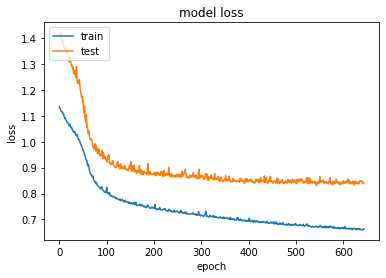

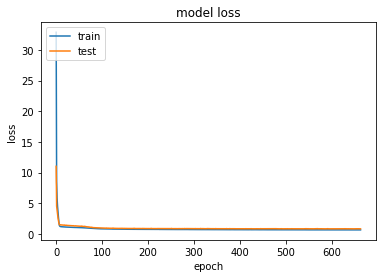

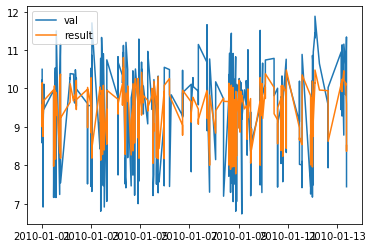

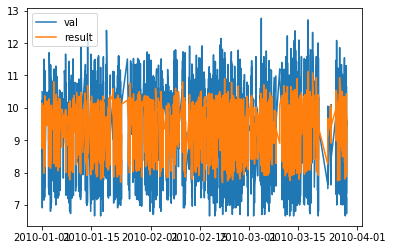

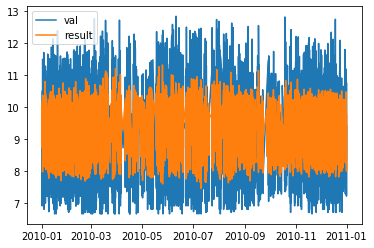

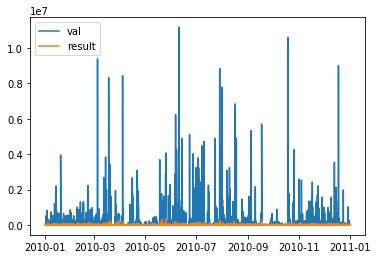

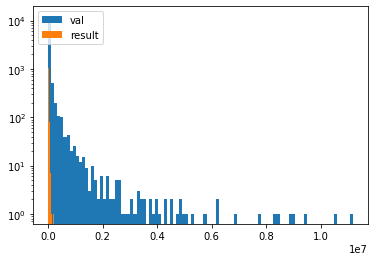

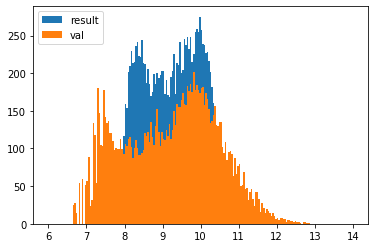

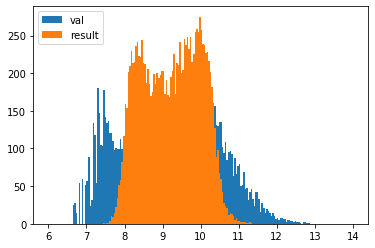

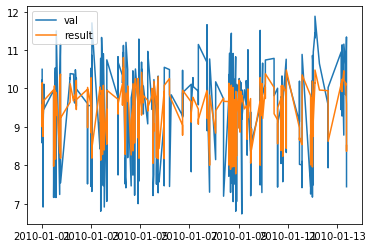

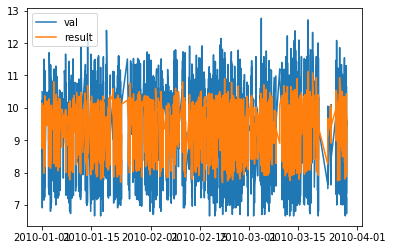

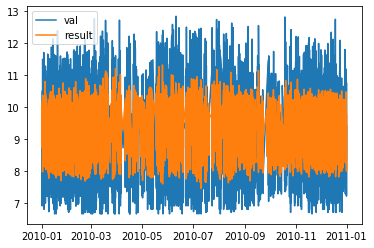

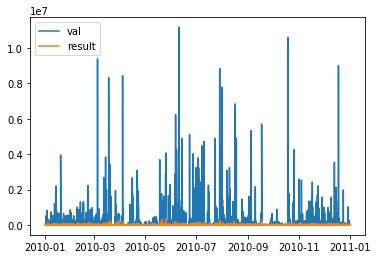

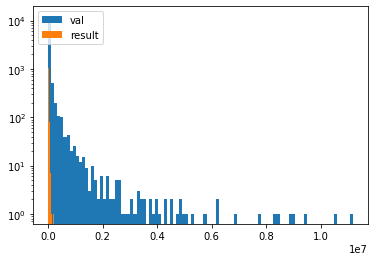

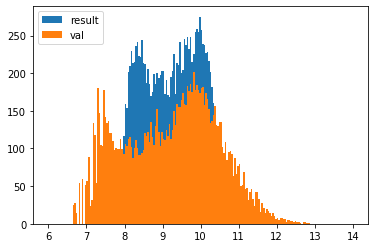

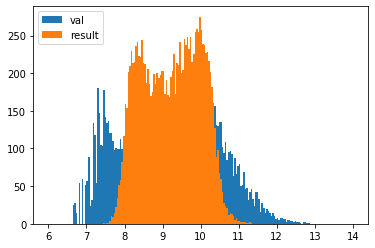

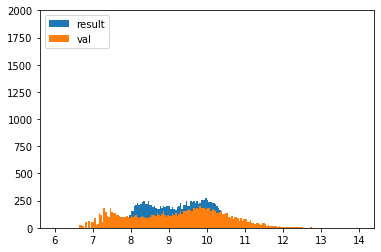

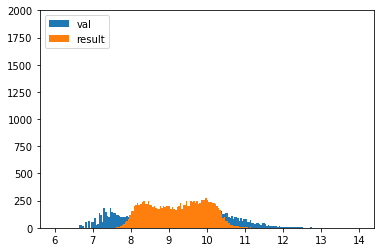

In [11]:
results = modelP.predict(X_val_P)
y_val_log = y_val_log_P


plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



df_results = pd.DataFrame(data=results, index = y_val_log.index)

%matplotlib inline

plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.ylim([0,2000])
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.ylim([0,2000])

plt.show()

In [16]:
avg_mse = (y_val_log_E.shape[0]*0.4508+y_val_log_A.shape[0]*0.5433+y_val_log_P.shape[0]*0.8383)/(y_val_log_E.shape[0]+y_val_log_A.shape[0]+y_val_log_P.shape[0])

In [17]:
print(avg_mse)

0.570673528346314


In [18]:
y_val_log = np.log10(y_val.copy(deep=True))


# JZ optimal model #3
modelall = k.models.Sequential()
modelall.add(k.layers.Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
modelall.add(k.layers.Dropout(0.5))
modelall.add(k.layers.Dense(64,  activation='relu'))
modelall.add(k.layers.Dense(32, activation='relu'))
modelall.add(k.layers.Dense(256, activation='relu'))
modelall.add(k.layers.Dense(1024, activation='relu'))
modelall.add(k.layers.Dense(256,  activation='relu'))
modelall.add(k.layers.Dense(32, activation='relu'))
modelall.add(k.layers.Dense(4,  activation='relu'))    
modelall.add(k.layers.Dense(1,  activation='linear'))

# FIT THE MODEL
modelall.compile(loss='mse',
              optimizer = k.optimizers.Adam(),
              metrics=['logcosh','mse','mae'])
history = modelall.fit(
                   X_train_scaled, y_train_log.values,
                    epochs=1000, 
                    batch_size=32768,
                    validation_data=(X_val_scaled, y_val_log.values),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    restore_best_weights=True,   patience=100)]    
                   )

Epoch 1/1000
57/57 [==============================] - 3s 48ms/step - loss: 17.8324 - logcosh: 2.4774 - mse: 17.8324 - mae: 3.0720 - val_loss: 2.9689 - val_logcosh: 0.8945 - val_mse: 2.9689 - val_mae: 1.4356
Epoch 2/1000
57/57 [==============================] - 3s 46ms/step - loss: 2.0799 - logcosh: 0.6415 - mse: 2.0799 - mae: 1.1286 - val_loss: 2.2475 - val_logcosh: 0.7856 - val_mse: 2.2475 - val_mae: 1.3578
Epoch 3/1000
57/57 [==============================] - 3s 47ms/step - loss: 1.5193 - logcosh: 0.5224 - mse: 1.5193 - mae: 0.9983 - val_loss: 2.1992 - val_logcosh: 0.7745 - val_mse: 2.1992 - val_mae: 1.3437
Epoch 4/1000
57/57 [==============================] - 3s 45ms/step - loss: 1.4450 - logcosh: 0.5014 - mse: 1.4450 - mae: 0.9706 - val_loss: 2.0100 - val_logcosh: 0.7144 - val_mse: 2.0100 - val_mae: 1.2732
Epoch 5/1000
57/57 [==============================] - 3s 44ms/step - loss: 1.3701 - logcosh: 0.4778 - mse: 1.3701 - mae: 0.9374 - val_loss: 1.8333 - val_logcosh: 0.6574 - val_mse

Epoch 41/1000
57/57 [==============================] - 3s 44ms/step - loss: 0.5404 - logcosh: 0.2129 - mse: 0.5404 - mae: 0.5469 - val_loss: 0.8097 - val_logcosh: 0.3221 - val_mse: 0.8097 - val_mae: 0.7522
Epoch 42/1000
57/57 [==============================] - 3s 44ms/step - loss: 0.5414 - logcosh: 0.2132 - mse: 0.5414 - mae: 0.5474 - val_loss: 0.8113 - val_logcosh: 0.3228 - val_mse: 0.8113 - val_mae: 0.7534
Epoch 43/1000
57/57 [==============================] - 3s 48ms/step - loss: 0.5342 - logcosh: 0.2107 - mse: 0.5342 - mae: 0.5433 - val_loss: 0.8425 - val_logcosh: 0.3341 - val_mse: 0.8425 - val_mae: 0.7690
Epoch 44/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.5364 - logcosh: 0.2114 - mse: 0.5364 - mae: 0.5443 - val_loss: 0.8097 - val_logcosh: 0.3219 - val_mse: 0.8097 - val_mae: 0.7517
Epoch 45/1000
57/57 [==============================] - 3s 44ms/step - loss: 0.5324 - logcosh: 0.2101 - mse: 0.5324 - mae: 0.5421 - val_loss: 0.8258 - val_logcosh: 0.3285 - val_

Epoch 81/1000
57/57 [==============================] - 3s 45ms/step - loss: 0.4882 - logcosh: 0.1936 - mse: 0.4882 - mae: 0.5119 - val_loss: 0.7683 - val_logcosh: 0.3048 - val_mse: 0.7683 - val_mae: 0.7206
Epoch 82/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4868 - logcosh: 0.1931 - mse: 0.4868 - mae: 0.5109 - val_loss: 0.8296 - val_logcosh: 0.3273 - val_mse: 0.8296 - val_mae: 0.7533
Epoch 83/1000
57/57 [==============================] - 3s 45ms/step - loss: 0.4897 - logcosh: 0.1941 - mse: 0.4897 - mae: 0.5127 - val_loss: 0.7742 - val_logcosh: 0.3077 - val_mse: 0.7742 - val_mae: 0.7262
Epoch 84/1000
57/57 [==============================] - 3s 45ms/step - loss: 0.4884 - logcosh: 0.1936 - mse: 0.4884 - mae: 0.5119 - val_loss: 0.7451 - val_logcosh: 0.2956 - val_mse: 0.7451 - val_mae: 0.7054
Epoch 85/1000
57/57 [==============================] - 3s 45ms/step - loss: 0.4859 - logcosh: 0.1927 - mse: 0.4859 - mae: 0.5100 - val_loss: 0.7394 - val_logcosh: 0.2930 - val_

Epoch 121/1000
57/57 [==============================] - 3s 49ms/step - loss: 0.4619 - logcosh: 0.1830 - mse: 0.4619 - mae: 0.4896 - val_loss: 0.6631 - val_logcosh: 0.2622 - val_mse: 0.6631 - val_mae: 0.6364
Epoch 122/1000
57/57 [==============================] - 3s 48ms/step - loss: 0.4599 - logcosh: 0.1822 - mse: 0.4599 - mae: 0.4880 - val_loss: 0.6714 - val_logcosh: 0.2656 - val_mse: 0.6714 - val_mae: 0.6441
Epoch 123/1000
57/57 [==============================] - 3s 48ms/step - loss: 0.4611 - logcosh: 0.1827 - mse: 0.4611 - mae: 0.4890 - val_loss: 0.6576 - val_logcosh: 0.2586 - val_mse: 0.6576 - val_mae: 0.6274
Epoch 124/1000
57/57 [==============================] - 3s 48ms/step - loss: 0.4568 - logcosh: 0.1811 - mse: 0.4568 - mae: 0.4854 - val_loss: 0.6625 - val_logcosh: 0.2618 - val_mse: 0.6625 - val_mae: 0.6354
Epoch 125/1000
57/57 [==============================] - 3s 48ms/step - loss: 0.4588 - logcosh: 0.1818 - mse: 0.4588 - mae: 0.4869 - val_loss: 0.6810 - val_logcosh: 0.2672 -

Epoch 200/1000
57/57 [==============================] - 3s 44ms/step - loss: 0.4330 - logcosh: 0.1717 - mse: 0.4330 - mae: 0.4659 - val_loss: 0.5973 - val_logcosh: 0.2314 - val_mse: 0.5973 - val_mae: 0.5692
Epoch 201/1000
57/57 [==============================] - 3s 44ms/step - loss: 0.4354 - logcosh: 0.1727 - mse: 0.4354 - mae: 0.4679 - val_loss: 0.5877 - val_logcosh: 0.2282 - val_mse: 0.5877 - val_mae: 0.5640
Epoch 202/1000
57/57 [==============================] - 3s 45ms/step - loss: 0.4331 - logcosh: 0.1717 - mse: 0.4331 - mae: 0.4660 - val_loss: 0.5993 - val_logcosh: 0.2327 - val_mse: 0.5993 - val_mae: 0.5743
Epoch 203/1000
57/57 [==============================] - 3s 44ms/step - loss: 0.4337 - logcosh: 0.1720 - mse: 0.4337 - mae: 0.4665 - val_loss: 0.6108 - val_logcosh: 0.2372 - val_mse: 0.6108 - val_mae: 0.5819
Epoch 204/1000
57/57 [==============================] - 3s 45ms/step - loss: 0.4342 - logcosh: 0.1722 - mse: 0.4342 - mae: 0.4669 - val_loss: 0.5988 - val_logcosh: 0.2321 -

Epoch 279/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4237 - logcosh: 0.1683 - mse: 0.4237 - mae: 0.4593 - val_loss: 0.5993 - val_logcosh: 0.2319 - val_mse: 0.5993 - val_mae: 0.5709
Epoch 280/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4245 - logcosh: 0.1686 - mse: 0.4245 - mae: 0.4598 - val_loss: 0.5739 - val_logcosh: 0.2212 - val_mse: 0.5739 - val_mae: 0.5483
Epoch 281/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4232 - logcosh: 0.1681 - mse: 0.4232 - mae: 0.4589 - val_loss: 0.5861 - val_logcosh: 0.2277 - val_mse: 0.5861 - val_mae: 0.5653
Epoch 282/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4224 - logcosh: 0.1677 - mse: 0.4224 - mae: 0.4579 - val_loss: 0.5961 - val_logcosh: 0.2318 - val_mse: 0.5961 - val_mae: 0.5734
Epoch 283/1000
57/57 [==============================] - 3s 45ms/step - loss: 0.4220 - logcosh: 0.1676 - mse: 0.4220 - mae: 0.4578 - val_loss: 0.6070 - val_logcosh: 0.2364 -

Epoch 358/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4153 - logcosh: 0.1652 - mse: 0.4153 - mae: 0.4532 - val_loss: 0.5834 - val_logcosh: 0.2220 - val_mse: 0.5834 - val_mae: 0.5443
Epoch 359/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.4152 - logcosh: 0.1651 - mse: 0.4152 - mae: 0.4530 - val_loss: 0.5882 - val_logcosh: 0.2269 - val_mse: 0.5882 - val_mae: 0.5604
Epoch 360/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4151 - logcosh: 0.1651 - mse: 0.4151 - mae: 0.4529 - val_loss: 0.5955 - val_logcosh: 0.2294 - val_mse: 0.5955 - val_mae: 0.5643
Epoch 361/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.4147 - logcosh: 0.1649 - mse: 0.4147 - mae: 0.4526 - val_loss: 0.6092 - val_logcosh: 0.2337 - val_mse: 0.6092 - val_mae: 0.5705
Epoch 362/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.4178 - logcosh: 0.1661 - mse: 0.4178 - mae: 0.4553 - val_loss: 0.6022 - val_logcosh: 0.2321 -

Epoch 437/1000
57/57 [==============================] - 3s 48ms/step - loss: 0.4089 - logcosh: 0.1627 - mse: 0.4089 - mae: 0.4485 - val_loss: 0.5940 - val_logcosh: 0.2278 - val_mse: 0.5940 - val_mae: 0.5596
Epoch 438/1000
57/57 [==============================] - 3s 46ms/step - loss: 0.4086 - logcosh: 0.1627 - mse: 0.4086 - mae: 0.4487 - val_loss: 0.6313 - val_logcosh: 0.2377 - val_mse: 0.6313 - val_mae: 0.5705
Epoch 439/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.4104 - logcosh: 0.1634 - mse: 0.4104 - mae: 0.4503 - val_loss: 0.5893 - val_logcosh: 0.2243 - val_mse: 0.5893 - val_mae: 0.5484
Epoch 440/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.4090 - logcosh: 0.1629 - mse: 0.4090 - mae: 0.4491 - val_loss: 0.6204 - val_logcosh: 0.2337 - val_mse: 0.6204 - val_mae: 0.5628
Epoch 441/1000
57/57 [==============================] - 3s 47ms/step - loss: 0.4092 - logcosh: 0.1630 - mse: 0.4092 - mae: 0.4495 - val_loss: 0.5833 - val_logcosh: 0.2234 -

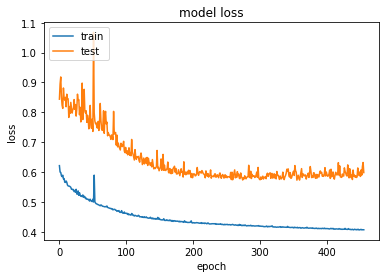

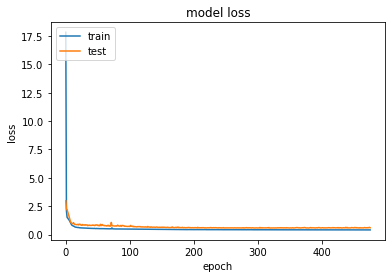

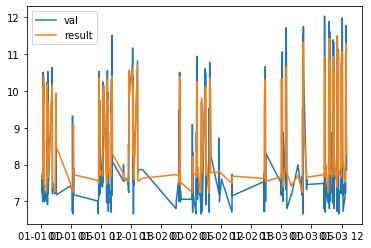

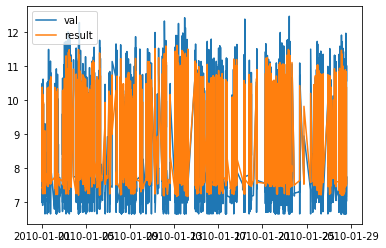

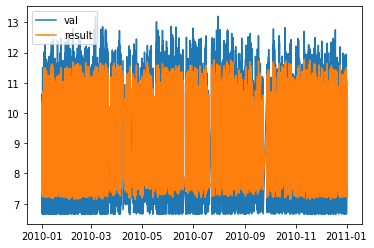

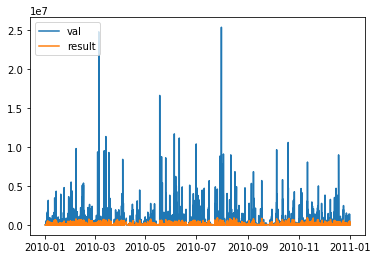

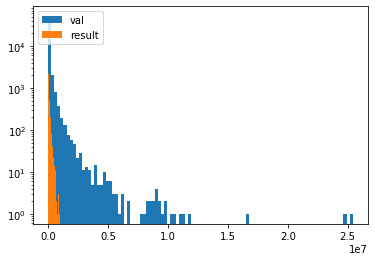

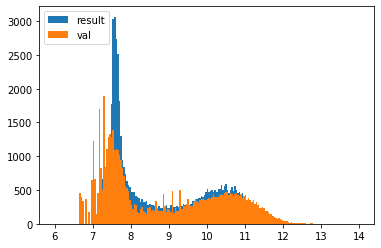

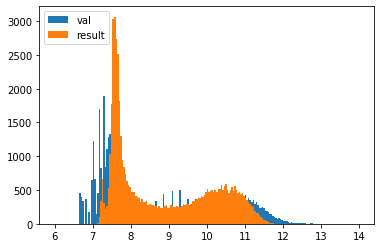

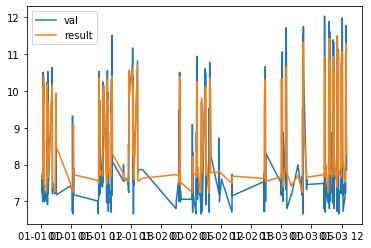

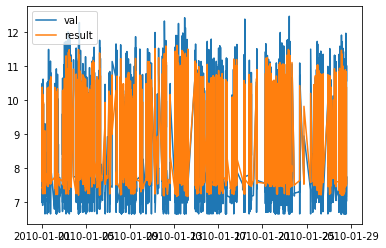

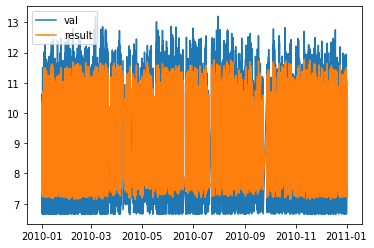

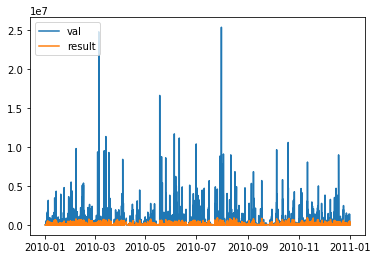

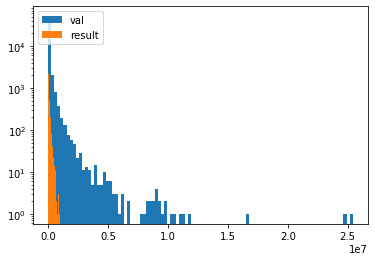

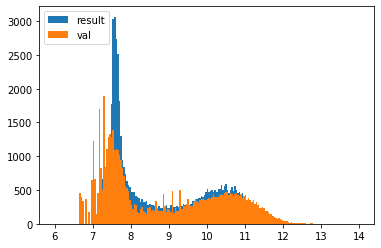

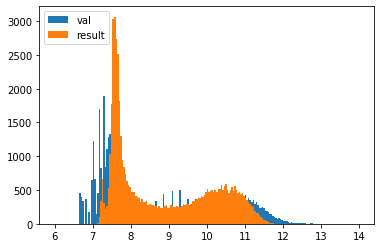

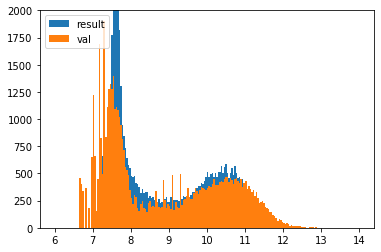

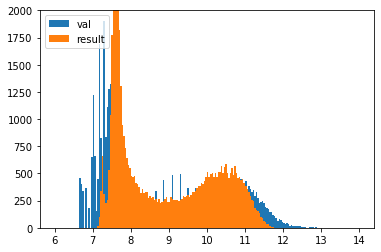

In [19]:
results = modelall.predict(X_val_scaled)


plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



df_results = pd.DataFrame(data=results, index = y_val_log.index)

%matplotlib inline

plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.ylim([0,2000])
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.ylim([0,2000])

plt.show()